# WOfS Validation Data Analysis - Water Body Type Classification  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2),
[ga_ls8c_wofs_2_annual_summary ](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_annual_summary)

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat 8 Collection 2 surface reflectance and shows surface water detected in Africa.
Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

The data in a WOFL is stored as a bit field. This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc). In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 
For more information on the structure of WOFLs and how to interact with them, see [Water Observations from Space](../Datasets/Water_Observations_from_Space.ipynb) and [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebooks.

## Description
This notebook explains how you can perform validation analysis for WOFS derived product using collected ground truth dataset and window-based sampling. 

The notebook demonstrates how to:

1. Load validation points for each partner institutions following cleaning stage as an ESRI shapefile
2. Query WOFL data for validation points and capture available WOfS observation available
3. Extract statistics for each WOfS observation in each validation point using a 3 by 3 window and multiprocessing functionality 
4. Extract a LUT for each point that contains both validation info and WOfS result for each month 
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import time 
import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio, rasterio.features
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from rasterio.mask import mask
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from sklearn import metrics 
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import plot_confusion_matrix, f1_score, mean_squared_error
from sklearn.metrics import jaccard_score
from deafrica_plotting import map_shapefile,display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_dask import create_local_dask_cluster

#for parallelisation 
from multiprocessing import Pool, Manager
import multiprocessing as mp
from tqdm import tqdm

### Analysis parameters

To analyse validation points collected by each partner institution, we need to obtain WOfS surface water observation data that corresponds with the labelled input data locations. 

### Loading Dataset

1. Load validation points for each partner institutions as a list of observations each has a location and month
    * Load the cleaned validation file as ESRI `shapefile`
    * Inspect the shapefile

In [2]:
#Read the ground truth data following analysis step 
CEO = '../Supplementary_data/Validation/Refined/Continent/Africa_validation_inland.csv'
input_data = pd.read_csv(CEO,delimiter=",")

In [3]:
input_data.count()

Unnamed: 0    9961
PLOT_ID       9961
LON           9961
LAT           9961
CLASS         9961
MONTH         9961
ACTUAL        9961
CLASS_WET     9961
CLEAR_OBS     9961
PREDICTION    9961
geometry      9961
dtype: int64

### Classification Based on CEO Labels and WOfS Observations 

In [4]:
#we need to loop over the table and set the value in Actual_WET as 1 and Actual_Dry as 0
for index, row in input_data.iterrows(): 
    if input_data.at[index,'ACTUAL'] == 1:
        input_data.at[index,'Actual_Wet'] = 1
    else:
        input_data.at[index,'Actual_Dry'] = 1

In [5]:
#convert the nan value in wet and dry columns of actual observations to zero values 
input_data['Actual_Wet'] = input_data['Actual_Wet'].fillna(0)
input_data['Actual_Dry'] = input_data['Actual_Dry'].fillna(0)

In [6]:
#set the Actual_Clear 
for index, row in input_data.iterrows(): 
    input_data.at[index,'Actual_Clear'] = input_data.at[index,'Actual_Wet'] + input_data.at[index,'Actual_Dry']

In [7]:
input_data.count()

Unnamed: 0      9961
PLOT_ID         9961
LON             9961
LAT             9961
CLASS           9961
MONTH           9961
ACTUAL          9961
CLASS_WET       9961
CLEAR_OBS       9961
PREDICTION      9961
geometry        9961
Actual_Wet      9961
Actual_Dry      9961
Actual_Clear    9961
dtype: int64

In [8]:
input_data['Actual_WET_T'] = input_data['Actual_Wet'].groupby(input_data['PLOT_ID']).transform('sum')

In [9]:
input_data['Actual_CLEAR_T'] = input_data['Actual_Clear'].groupby(input_data['PLOT_ID']).transform('sum')

In [10]:
input_data['WET_T'] = input_data['CLASS_WET'].groupby(input_data['PLOT_ID']).transform('sum')

In [11]:
input_data['CLEAR_T'] = input_data['CLEAR_OBS'].groupby(input_data['PLOT_ID']).transform('sum')

In [12]:
Summarize = input_data.groupby('PLOT_ID',as_index=False,sort=False).last()

In [13]:
Summarize['CEO_FREQUENCY'] = Summarize['Actual_WET_T']/Summarize['Actual_CLEAR_T']

In [14]:
Summarize['WOfS_FREQUENCY'] = Summarize['WET_T']/Summarize['CLEAR_T']

In [15]:
#Define water body classes for CEO based on thresholding 
Summarize.loc[Summarize['Actual_WET_T'] == 0.0, 'CEO_TYPE'] = 'Dry'
Summarize.loc[(Summarize['Actual_WET_T'] != 0.0) & (Summarize['CEO_FREQUENCY'] <= 0.9), 'CEO_TYPE'] = 'Ephemeral'  
Summarize.loc[(Summarize['Actual_WET_T'] != 0.0) & (Summarize['CEO_FREQUENCY'] > 0.9), 'CEO_TYPE'] = 'Permanent'

In [16]:
#Define water body classes for WOfS based on thresholding 
Summarize.loc[Summarize['WET_T'] == 0.0, 'WOfS_TYPE'] = 'Dry'
Summarize.loc[(Summarize['WET_T'] != 0.0) & (Summarize['WOfS_FREQUENCY'] <= 0.9), 'WOfS_TYPE'] = 'Ephemeral'  
Summarize.loc[(Summarize['WET_T'] != 0.0) & (Summarize['WOfS_FREQUENCY'] > 0.9), 'WOfS_TYPE'] = 'Permanent'

In [17]:
Summarize.to_csv(('../Supplementary_data/Validation/Refined/Continent/WOfS_Summary/Africa_WOfS_validation_inland_Summarize_T0.9_update.csv'))

### Extract the AEZ-based Validation Data Points from Africa Continental Dataset  

In [18]:
#Read the ground truth data following analysis step 
CEO = '../Supplementary_data/Validation/Refined/Continent/WOfS_Summary/Africa_WOfS_validation_inland_Summarize_T0.9_update.csv'
# CEO = '../Supplementary_data/Validation/Refined/AFRIGIST/Groundtruth_AfriGIST_W305m.csv'
df = pd.read_csv(CEO,delimiter=",")

In [19]:
df.columns

Index(['Unnamed: 0', 'PLOT_ID', 'Unnamed: 0.1', 'LON', 'LAT', 'CLASS', 'MONTH',
       'ACTUAL', 'CLASS_WET', 'CLEAR_OBS', 'PREDICTION', 'geometry',
       'Actual_Wet', 'Actual_Dry', 'Actual_Clear', 'Actual_WET_T',
       'Actual_CLEAR_T', 'WET_T', 'CLEAR_T', 'CEO_FREQUENCY', 'WOfS_FREQUENCY',
       'CEO_TYPE', 'WOfS_TYPE'],
      dtype='object')

In [20]:
#input_data=df.drop(['Unnamed: 0'], axis=1)
input_data=df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [21]:
geometry = [Point(xy) for xy in zip(input_data.LON, input_data.LAT)]
crs = {'init': 'epsg:4326'} 
ValPoints = GeoDataFrame(input_data, crs=crs, geometry=geometry)

In [22]:
#Reading the boundary file for African countries 
aez = '../Supplementary_data/Validation/Refined/Continent/shapefile/AEZs_simple_IndianOcean.shp'

In [23]:
outline = gpd.read_file(aez).to_crs('EPSG:4326')
#outline

In [24]:
#Clipping the input data with the buffer zone to have all inland points that are not coastal 
include_points = gpd.clip(ValPoints, outline)

In [25]:
include_points.to_csv(('../Supplementary_data/Validation/Refined/Continent/AEZs_Assessment/Africa_WOfS_Validation_Class_IndianOcean_T0.9_update.csv'))

### Accuracy Assessment 

In order to assess the tables extracted from WOfS or S2 tables as above classification for the type of water bodies i.e. dry, ephemeral, and permanent, please use the following cells: 

In [26]:
#Reading the classification table extracted  from 0.9 thresholding of the frequncy for each AEZ exteracted from WOfS_Validation_Africa notebook 
SummaryTable = '../Supplementary_data/Validation/Refined/Continent/AEZs_Assessment/Africa_WOfS_Validation_Class_IndianOcean_T0.9_update.csv'
CLF = pd.read_csv(SummaryTable,delimiter=",")
CLF.columns

Index(['Unnamed: 0', 'PLOT_ID', 'LON', 'LAT', 'CLASS', 'MONTH', 'ACTUAL',
       'CLASS_WET', 'CLEAR_OBS', 'PREDICTION', 'geometry', 'Actual_Wet',
       'Actual_Dry', 'Actual_Clear', 'Actual_WET_T', 'Actual_CLEAR_T', 'WET_T',
       'CLEAR_T', 'CEO_FREQUENCY', 'WOfS_FREQUENCY', 'CEO_TYPE', 'WOfS_TYPE'],
      dtype='object')

In [27]:
CLF=CLF.drop(['Unnamed: 0','MONTH','ACTUAL','CLASS_WET','CLEAR_OBS','PREDICTION','geometry','Actual_Wet','Actual_Dry','Actual_Clear'], axis=1)
CLF

,PLOT_ID,LON,LAT,CLASS,Actual_WET_T,Actual_CLEAR_T,WET_T,CLEAR_T,CEO_FREQUENCY,WOfS_FREQUENCY,CEO_TYPE,WOfS_TYPE
0,137387482,48.926542,-13.044613,Open water - freshwater,10.0,10.0,10,15,1.000000,0.666667,Permanent,Ephemeral
1,137387483,49.060861,-13.143534,Open water - freshwater,8.0,8.0,6,10,1.000000,0.600000,Permanent,Ephemeral
2,137387485,49.040962,-13.273155,Wetlands - freshwater,2.0,9.0,2,12,0.222222,0.166667,Ephemeral,Ephemeral
3,137387486,48.994945,-13.373374,Shrubs,0.0,10.0,0,14,0.000000,0.000000,Dry,Dry
4,137387487,49.562072,-13.373374,Open water - freshwater,8.0,8.0,4,13,1.000000,0.307692,Permanent,Ephemeral
...,...,...,...,...,...,...,...,...,...,...,...,...
208,137387753,46.602999,-25.161405,Wetlands - freshwater,2.0,11.0,6,41,0.181818,0.146341,Ephemeral,Ephemeral
209,137387754,44.392011,-25.174624,Barren (Bare soil / Rocky Land),0.0,10.0,6,20,0.000000,0.300000,Dry,Ephemeral
210,137387756,44.370868,-25.211956,Wetlands - marine (e.g. mangroves),6.0,11.0,11,37,0.545455,0.297297,Ephemeral,Ephemeral
211,137387757,44.916230,-25.221032,Shrubs,0.0,12.0,0,42,0.000000,0.000000,Dry,Dry


In [28]:
confusion_matrix = pd.crosstab(CLF['CEO_TYPE'],CLF['WOfS_TYPE'],rownames=['CEO'],colnames=['WOfS'],margins=True)

In [29]:
confusion_matrix["User's"] = [confusion_matrix.loc['Dry']['Dry'] / confusion_matrix.loc['Dry']['All'] * 100, confusion_matrix.loc['Ephemeral']['Ephemeral'] / confusion_matrix.loc['Ephemeral']['All'] *100, confusion_matrix.loc['Permanent']['Permanent'] / confusion_matrix.loc['Permanent']['All'] *100,np.nan]

In [30]:
producers_accuracy = pd.Series([confusion_matrix['Dry']['Dry'] / confusion_matrix['Dry']['All'] * 100,
                                confusion_matrix['Ephemeral']['Ephemeral'] / confusion_matrix['Ephemeral']['All'] * 100,
                                confusion_matrix['Permanent']['Permanent'] / confusion_matrix['Permanent']['All'] * 100]).rename("Producer's")

confusion_matrix = confusion_matrix.append(producers_accuracy)

In [31]:
confusion_matrix.loc["Producer's", "User's"] = (confusion_matrix['Dry']['Dry'] + confusion_matrix['Ephemeral']['Ephemeral'] + confusion_matrix['Permanent']['Permanent']) / confusion_matrix['All']['All'] * 100
confusion_matrix

,Dry,Ephemeral,Permanent,All,User's,0,1,2
CEO,,,,,,,,
Dry,35.0,6.0,0.0,41.0,85.365854,NaN,NaN,NaN
Ephemeral,0.0,28.0,0.0,28.0,100.000000,NaN,NaN,NaN
Permanent,1.0,142.0,1.0,144.0,0.694444,NaN,NaN,NaN
All,36.0,176.0,1.0,213.0,NaN,NaN,NaN,NaN
Producer's,NaN,NaN,NaN,NaN,30.046948,97.222222,15.909091,100.0


In [32]:
print(metrics.classification_report(CLF['CEO_TYPE'], CLF['WOfS_TYPE'], digits=3))

              precision    recall  f1-score   support

         Dry      0.972     0.854     0.909        41
   Ephemeral      0.159     1.000     0.275        28
   Permanent      1.000     0.007     0.014       144

    accuracy                          0.300       213
   macro avg      0.710     0.620     0.399       213
weighted avg      0.884     0.300     0.220       213



In [33]:
sn.set()
sn.set_theme(color_codes=True)

In [34]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [35]:
r_value = r2(CLF["CEO_FREQUENCY"], CLF["WOfS_FREQUENCY"])
r_value_r = round(r_value, 3)

In [36]:
rmse = (np.sqrt(mean_squared_error(CLF['CEO_FREQUENCY'],CLF['WOfS_FREQUENCY'])))

In [37]:
jaccard_score(CLF["CEO_TYPE"], CLF["WOfS_TYPE"], average=None)

array([0.83333333, 0.15909091, 0.00694444])

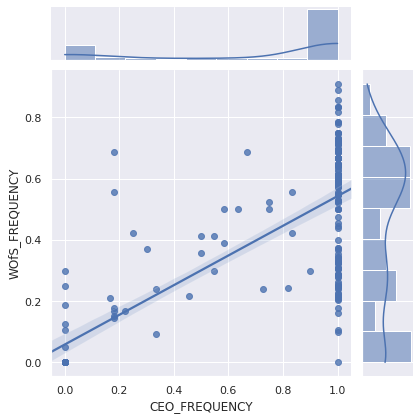

In [38]:
#In order to plot Probability Density functions of each variable, you need to use kind='kde'
ax = sn.jointplot(CLF["CEO_FREQUENCY"], CLF["WOfS_FREQUENCY"], data=CLF, kind='reg', truncate=None);

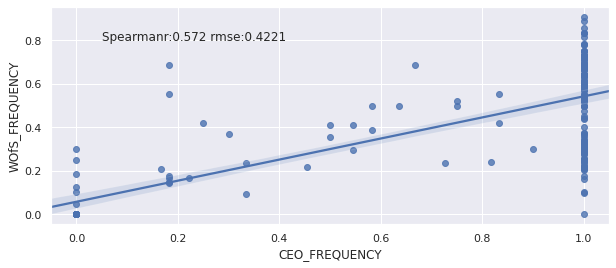

In [39]:
plt.figure(figsize=(10,4))
j = sn.regplot(data=CLF, x='CEO_FREQUENCY', y='WOfS_FREQUENCY',truncate=False);
j.annotate('Spearmanr:'+str(r_value_r) + ' ' + 'rmse:' + str(round(rmse,4)), xy=(0.05, 0.8));

In [40]:
Sample_ID = CLF[['CLASS','CEO_FREQUENCY','WOfS_FREQUENCY']] 

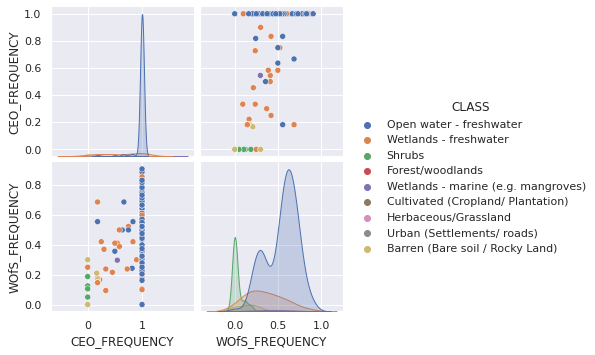

In [41]:
sn.pairplot(Sample_ID, hue='CLASS', size=2.5);

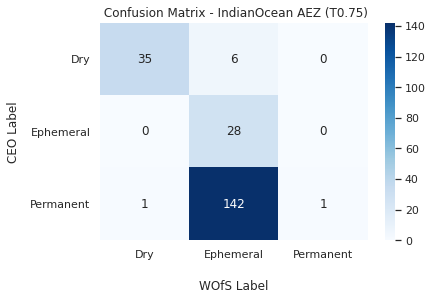

In [42]:
confusion_matrix = pd.crosstab(CLF['CEO_TYPE'],CLF['WOfS_TYPE'],rownames=['CEO'],colnames=['WOfS'])
ax = plt.subplot()
sn.heatmap(confusion_matrix, annot = True, cmap='Blues', fmt='g') #true to annotate cells 
ax.set_xlabel('WOfS Label'); ax.set_ylabel( 'CEO Label');
ax.set_title(' Confusion Matrix - IndianOcean AEZ (T0.75)')
ax.xaxis.set_ticklabels(['Dry','Ephemeral','Permanent']); 
ax.yaxis.set_ticklabels(['Dry','Ephemeral','Permanent'], rotation='horizontal');
ax.xaxis.labelpad = 20;
ax.yaxis.labelpad = 10;

In [43]:
confusion_matrix = pd.crosstab(CLF['CLASS'],CLF['WOfS_TYPE'],rownames=['CLASS'],colnames=['WOfS_TYPE'],margins=True)
confusion_matrix

WOfS_TYPE,Dry,Ephemeral,Permanent,All
CLASS,,,,
Barren (Bare soil / Rocky Land),2,4,0,6
Cultivated (Cropland/ Plantation),2,0,0,2
Forest/woodlands,6,0,0,6
Herbaceous/Grassland,7,0,0,7
Open water - freshwater,1,136,1,138
Shrubs,14,4,0,18
Urban (Settlements/ roads),2,0,0,2
Wetlands - freshwater,2,30,0,32
Wetlands - marine (e.g. mangroves),0,2,0,2


In [44]:
confusion_matrix2 = pd.crosstab(CLF['CLASS'],CLF['CEO_TYPE'],rownames=['CLASS'],colnames=['CEO_TYPE'],margins=True)
confusion_matrix2

CEO_TYPE,Dry,Ephemeral,Permanent,All
CLASS,,,,
Barren (Bare soil / Rocky Land),3,3,0,6
Cultivated (Cropland/ Plantation),2,0,0,2
Forest/woodlands,6,0,0,6
Herbaceous/Grassland,7,0,0,7
Open water - freshwater,0,7,131,138
Shrubs,18,0,0,18
Urban (Settlements/ roads),2,0,0,2
Wetlands - freshwater,3,17,12,32
Wetlands - marine (e.g. mangroves),0,1,1,2


### Classification Based on WOfS or S2 SCL Extracted Tables

In [ ]:
# input_data['WET_T'] = input_data['CLASS_WET'].groupby(input_data['PLOT_ID']).transform('sum')

In [ ]:
# input_data['CLEAR_T'] = input_data['CLEAR_OBS'].groupby(input_data['PLOT_ID']).transform('sum')

In [ ]:
# Summarize = input_data.groupby('PLOT_ID',as_index=False,sort=False).last()

In [ ]:
# Summarize['FREQUENCY'] = Summarize['WET_T']/Summarize['CLEAR_T']

In [ ]:
# Summarize.loc[Summarize['WET_T'] == 0.0, 'TYPE'] = 'Dry'
# Summarize.loc[(Summarize['WET_T'] != 0.0) & (Summarize['FREQUENCY'] <= 0.9), 'TYPE'] = 'Ephemeral'  
# Summarize.loc[(Summarize['WET_T'] != 0.0) & (Summarize['FREQUENCY'] > 0.9), 'TYPE'] = 'Permanent'  

In [ ]:
#Summarize

In [ ]:
#Summarize.to_csv(('../Supplementary_data/Validation/Refined/Continent/WOfS_Summary/Africa_validation_inland_Summarize_T0.9.csv'))

In [ ]:
print(datacube.__version__)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** September 2020

**Compatible datacube version:** 

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)